<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem


import pylab as plt
%matplotlib inline

In [2]:
# datos
ducks= pd.read_csv(r'../6.4_lab-AB-Testing/data/cookie_cats.csv', index_col= False)
ducks

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [3]:
ducks.userid.value_counts()

116        1
6632278    1
6658202    1
6658194    1
6658134    1
          ..
3347358    1
3347337    1
3346992    1
3346979    1
9999861    1
Name: userid, Length: 90189, dtype: int64

In [4]:
# transformacion

ducks.retention_1.value_counts()



False    50036
True     40153
Name: retention_1, dtype: int64

In [5]:
ducks.retention_7.value_counts()

False    73408
True     16781
Name: retention_7, dtype: int64

In [6]:
pd.crosstab(ducks.version, ducks.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [7]:
pd.crosstab(ducks.version, ducks.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [8]:
cats_30 = ducks[ducks.version == 'gate_30']

In [9]:
cats_40 = ducks[ducks.version == 'gate_40']

In [10]:
#muestreo

In [11]:
control = cats_30
tratamiento = cats_40
ab_test = pd.concat([control, tratamiento], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


# TESTEO RETENCION_1

In [12]:
# pip install -U Jinja2
#pip uninstall pylab

In [13]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


In [40]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], 
            y=ab_test['converted'])

plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

KeyError: 'group'

<Figure size 576x432 with 0 Axes>

In [28]:

control_res=ab_test[ab_test.version=='gate_30']['retention_1']  # version es por lo que quieres coger la columna

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']


In [29]:
observaciones = [control_res.count(), trat_res.count()]


conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [30]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


# RETENTION_7

In [35]:

control_res=ab_test[ab_test.version=='gate_30']['retention_7']  # version es por lo que quieres coger la columna

trat_res=ab_test[ab_test.version=='gate_40']['retention_7']


In [36]:
observaciones = [control_res.count(), trat_res.count()]
conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [37]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]


In [24]:
from scipy.stats import norm
import pylab as plt
import matplotlib.pyplot as plt 



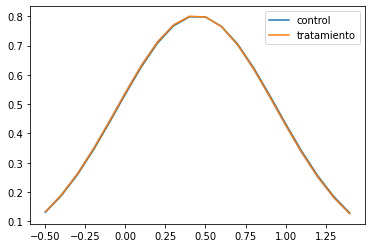

In [39]:
x=[i*.1 for i in range(-5, 15)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

''' En la retención 1 vemos que la hipotesis nula es correcta, lo cual indica que no hay cambios significantes en el testeo. 
    Aunque un poco por encima lo cual son cercanas con muy poca diferencia.

    En la retención 7 es H1 - indicando que nos quedariamos con que podria ayudar a que cambairamos el diseño a Gate_40
    hay que decir que la diferencia sigue siendo pequeña, cercana al 0.005 por lo que habría que evaluar si merece el cambio, aunque la decisión
    es mas clara que en el primer analisis de la retención a día 1. Los intervalos de confianza de la ret7

'''

# BAYES 

In [51]:
ducks.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [50]:
ducks[ducks(['version'] == 'gate_30') & (['retention_1'] == True )].count()


TypeError: 'DataFrame' object is not callable

In [ ]:
ducks.version.count()

In [52]:
imps_ctrl, convs_ctrl = 90189, 30   # entrar, comprar
imps_test, convs_test= 17000, 50


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.00033263480025280245, Test=0.0029411764705882353'

In [ ]:
final viendo si me deja hacer el pull

In [ ]:
final viendo si me deja hacer el pull